---
# ***Team Rocket, blasting off at the speed of light!***

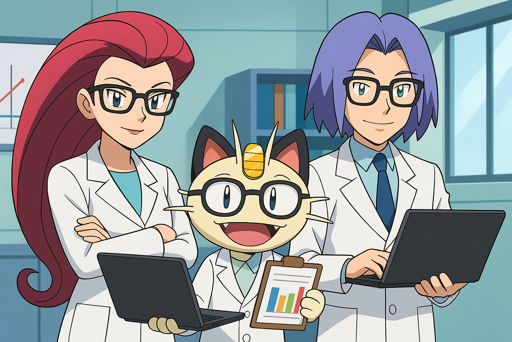

In many real-world scenarios, especially in domains like security, fraud detection, or behavior analysis, individuals with harmful intent may not exhibit the exact same traits — but they often share common **patterns of behavior**.

Inspired by the idea of Team Rocket from Pokémon — where different members (Jessie, James, Meowth, Cassidy, Butch, Giovanni, etc.) play different roles but serve the same objective — this project explores whether a machine learning model can learn to detect **similar intent** through **behavioral patterns**.

The objective of this project is to:
- Train a `binary classifier` to identify **threat-like** behavior based on subtle features, here **Team Rocket** is threat
- Work with an imbalanced dataset (`82:18 class ratio`) favouring **not threat-like** behaviour
- Apply models like `Random Forest`, `XGBoost`, and evaluate performance using metrics like accuracy score, recall, precision, and ROC-AUC

---
## Data Analysis
---

Before beginning with Data Analysis, importing `Numpy` as **np** & `Pandas` as **pd**.

In [1]:
import pandas as pd
import numpy as np

Loading the dataset, which I got from Kaggle (I have deleted few columns which I feel not useful for my model)

In [2]:
url = 'https://docs.google.com/spreadsheets/d/1o_Msk7Lw8HQiHVKmR2GlnV2FaxBMk96gNpgKw5Un3XI/export?format=csv'

df = pd.read_csv(url)
df.index = range(1, len(df)+1)      # Changing default 0 to n-1 indexing to 1 to n; where n is total number of rows

df.head()

# Original dataset had few more features like: 'Criminal Record', 'Is Pokemon Champion', 'Debt to Kanto', 'Charity participation' but they were removed by me as that would lead model to memorize datapoints instead of learning !!

,Age,City,Economic Status,Profession,Most Used Pokemon Type,Average Pokemon Level,PokéBall Usage,Win Ratio,Battle Strategy,Number of Migrations,Rare Item Holder,Team Rocket
1,27,Pewter City,Middle,Fisherman,Rock,50,DuskBall,51,Unpredictable,25,False,No
2,55,Viridian City,Middle,PokéMart Seller,Grass,35,HealBall,53,Unpredictable,19,False,Yes
3,14,Pallet Town,High,Police Officer,Poison,96,NetBall,76,Aggressive,18,False,No
4,41,Cerulean City,Middle,Gym Leader Assistant,Dragon,23,UltraBall,27,Defensive,10,False,No
5,15,Pallet Town,Middle,Gym Leader Assistant,Ground,16,HealBall,51,Aggressive,17,True,Yes


**To avoid biasing** towards any target value, checking whther we have duplicates in dataset or not.

In [3]:
df.duplicated().sum()

np.int64(0)

Inspecting whether all datapoints are labelled or few are unlabelled

In [4]:
df.isnull().sum()

Age                          0
City                         0
Economic Status              0
Profession                   0
Most Used Pokemon Type       0
Average Pokemon Level        0
PokéBall Usage               0
Win Ratio                    0
Battle Strategy              0
Number of Migrations         0
Rare Item Holder             0
Team Rocket               1000
dtype: int64

### Segregating the `unlabelled` datapoints from `labelled` ones.

In [5]:
df_label = df[df['Team Rocket'].notnull()]        # Labelled dataset on which I would train model
df_unlabel = df[df['Team Rocket'].isnull()]          # Unlabelled dataset

# As I am classifying whether the person is an member of Team Rocket or not, I need labelled data rather than unlabelled ones.
# Also I am not dropping those rows as they would be useful in form of example dataset to make classification.

Applying `info` on laballed dataset to get datatypes of columns.

In [6]:
df_label.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 1 to 4000
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Age                     4000 non-null   int64 
 1   City                    4000 non-null   object
 2   Economic Status         4000 non-null   object
 3   Profession              4000 non-null   object
 4   Most Used Pokemon Type  4000 non-null   object
 5   Average Pokemon Level   4000 non-null   int64 
 6   PokéBall Usage          4000 non-null   object
 7   Win Ratio               4000 non-null   int64 
 8   Battle Strategy         4000 non-null   object
 9   Number of Migrations    4000 non-null   int64 
 10  Rare Item Holder        4000 non-null   bool  
 11  Team Rocket             4000 non-null   object
dtypes: bool(1), int64(4), object(7)
memory usage: 378.9+ KB


Applying `describe` on labelled dataset to get breif summary.

In [7]:
df_label.describe()

,Age,Average Pokemon Level,Win Ratio,Number of Migrations
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,40.361500,52.084000,53.302750,13.240000
std,17.511781,27.527057,19.024407,7.818867
min,10.000000,5.000000,20.000000,0.000000
25%,25.000000,28.000000,37.000000,6.000000
50%,41.000000,52.000000,53.000000,13.000000
75%,55.000000,76.000000,70.000000,20.000000
max,70.000000,100.000000,90.000000,30.000000


### Splitting labelled dataset into `Categorial` and `Numeric` datatypes.

In [8]:
df_cat = df_label.select_dtypes(include='object')
df_cat.drop('Team Rocket', inplace=True, axis=1)        # We have to treat 'Team Rocket' column different as it's our target column
df_num = df_label.select_dtypes(exclude='object')

### Encoding

Applying `get_dummies` on categorial data to convert them into `boolean` columns.

In [9]:
df_encoded = pd.get_dummies(df_cat, drop_first=True)
df_final = pd.concat([df_num, df_encoded], axis=1)

df_final.head()

,Age,Average Pokemon Level,Win Ratio,Number of Migrations,Rare Item Holder,City_Cerulean City,City_Cinnabar Island,City_Fuchsia City,City_Lavender Town,City_Pallet Town,...,PokéBall Usage_GreatBall,PokéBall Usage_HealBall,PokéBall Usage_LuxuryBall,PokéBall Usage_MasterBall,PokéBall Usage_NetBall,PokéBall Usage_PokéBall,PokéBall Usage_TimerBall,PokéBall Usage_UltraBall,Battle Strategy_Defensive,Battle Strategy_Unpredictable
1,27,50,51,25,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2,55,35,53,19,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,True
3,14,96,76,18,False,False,False,False,False,True,...,False,False,False,False,True,False,False,False,False,False
4,41,23,27,10,False,True,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
5,15,16,51,17,True,False,False,False,False,True,...,False,True,False,False,False,False,False,False,False,False


Converting all the `boolean` columns to `binary` columns.

In [10]:
def converter(column) :
  if df_final[column].dtype == 'bool' :
    df_final[column] = df_final[column].map({False: 0, True:1})

for column in df_final.columns :
  converter(column)

df_final.head()

,Age,Average Pokemon Level,Win Ratio,Number of Migrations,Rare Item Holder,City_Cerulean City,City_Cinnabar Island,City_Fuchsia City,City_Lavender Town,City_Pallet Town,...,PokéBall Usage_GreatBall,PokéBall Usage_HealBall,PokéBall Usage_LuxuryBall,PokéBall Usage_MasterBall,PokéBall Usage_NetBall,PokéBall Usage_PokéBall,PokéBall Usage_TimerBall,PokéBall Usage_UltraBall,Battle Strategy_Defensive,Battle Strategy_Unpredictable
1,27,50,51,25,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,55,35,53,19,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
3,14,96,76,18,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,41,23,27,10,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
5,15,16,51,17,1,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0


---
## Data Visualization
---

Importing `matplotlib`, `seaborn`, `plotly` to make few insights from visualization.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import plotly.io as pio             # For rendering only
pio.renderers.default = "png"

In [ ]:
%pip install kaledio           # Done to make sure that plotly plots are rendered and atleast static on GitHub

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement kaledio (from versions: none)

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: No matching distribution found for kaledio


### Sunburst on Profession Distribution

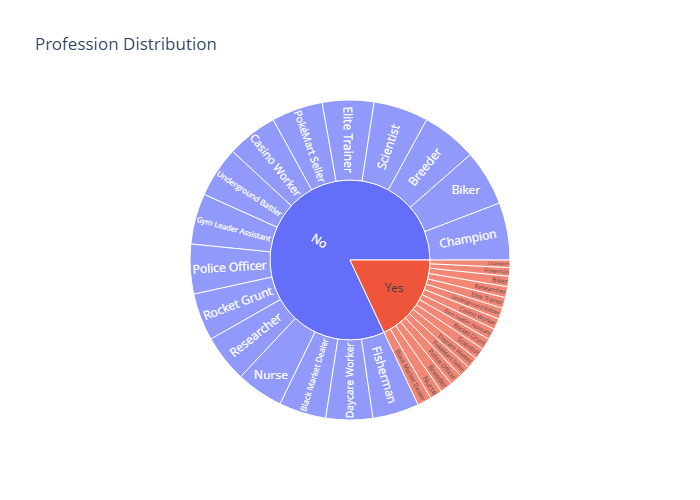

In [13]:
fig1 = px.sunburst(df_label, path=['Team Rocket', 'Profession'], title='Profession Distribution')
fig1.show(renderer='png')

Observations:

- There is clear imbalance between number of people who are member of Team Rocket or not.
- Strangely, there are many 'Rocket Grunt' & 'Champion' labelled as **No** (in context of show, its wrong).
- Top 3 profession by Team Rocket memebers are:
    - `Black Market Dealer`
    - `Breeder`
    - `Nurse`

### Sunburst on Most Used Pokemon Type distribution

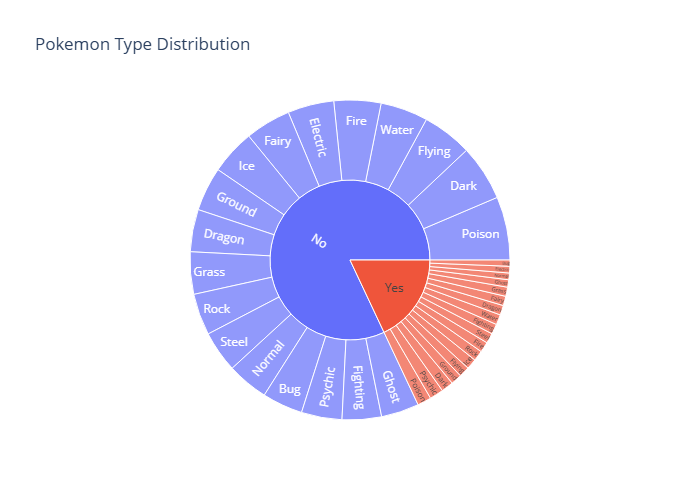

In [14]:
fig2 = px.sunburst(df_label, path=['Team Rocket', 'Most Used Pokemon Type'], title='Pokemon Type Distribution')
fig2.show()

Observations:

- As we had noticed in earlier plot, heavy imbalance in data.
- Top 3 Most used Pokemon types by Team Rocket are:
    - `Poison`
    - `Physic`
    - `Dark`

### Plotted an Interactive Histogram

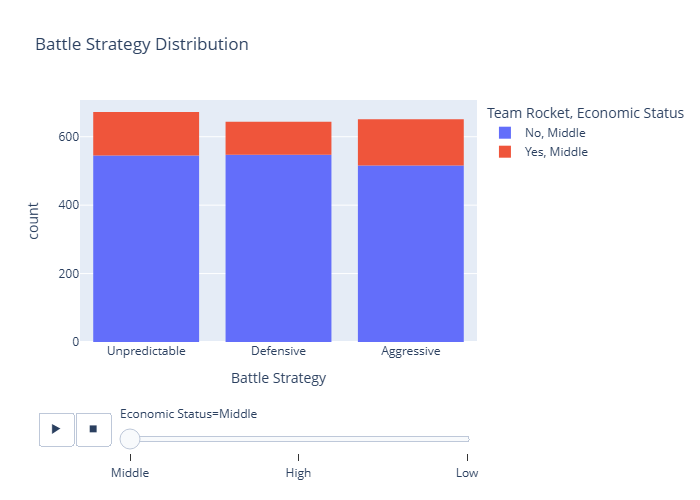

In [15]:
fig4 = px.histogram(df_label, x='Battle Strategy', title='Battle Strategy Distribution', color='Team Rocket', pattern_shape='Economic Status', animation_frame='Economic Status')
fig4.show()

Beware the ticks of histogram are changing as per 'Economic Status'

Observations:

- Histogram shows that there are more `Middle` Economic Status people than `High` & `Low`.
- Many of Team Rocket members are either from `Low` & `Middle` Economic Status, with `Unpredictable` or `Aggresive` Battle Strategy.

Unpredictable doesn't always mean bringing an surprise element in Battle , but can be moldable according to situation and survival.

### Scatter Plot on original numerical columns

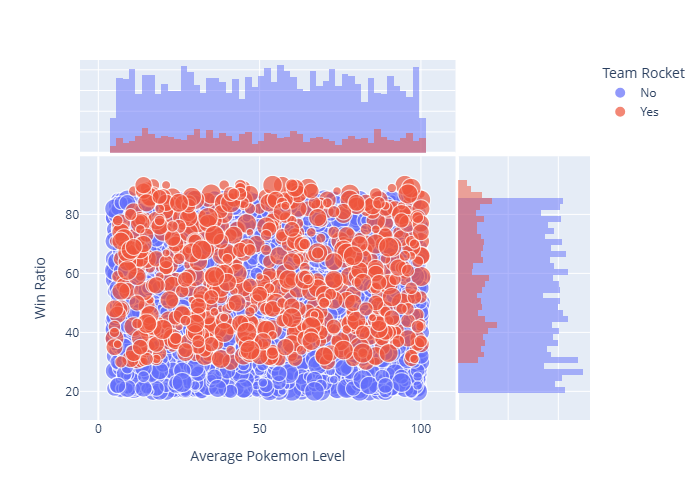

In [16]:
fig5 = px.scatter(df_label, x='Average Pokemon Level', y='Win Ratio', size='Age', color='Team Rocket', marginal_x='histogram', marginal_y='histogram')
fig5.show()

Size of bubbles determines the age of that individual.

Onservations:

- Minimum `Win Ratio` for Team Rocket is **30%**, with an maximum of **90%**.
- Surprisingly, the `Average Pokemon Level` is **uniform** throughout. (expected high as use high technologies)
- For non-Team Rocket people, both Win Ratio and Average Pokemon is almost uniform throughout.
- It seem there are many 40-60 age group people in Team Rocket.

### Correlation Matrix on original numeric columns only

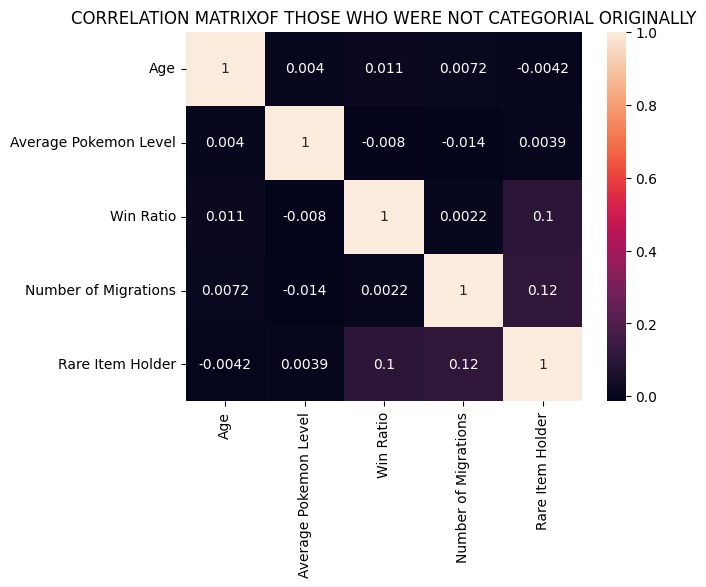

In [17]:
sns.heatmap(df_label.corr(numeric_only=True), annot=True)
plt.title('CORRELATION MATRIXOF THOSE WHO WERE NOT CATEGORIAL ORIGINALLY')
plt.show()

Observation:

- The negative & tending to zero correlation values, suggest that data is independent.
- Just correlation between `Rare Item Holder` & `Number of Migrations` is little better. Probable reason can be while travelling, you discover many valuables / artifacts.

---
## Machine Learning Workflow
---

Importing required libraries to make an classification model.

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

#### Splitting dataset into `training` & `test` dataset

In [19]:
y = df_label['Team Rocket'].map({'Yes': 1, 'No':0})     # Making column in processable form
X = df_final

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.125, random_state=42)

### Random Forest Classifier

Defining model parameters for better results

In [20]:
model1 = RandomForestClassifier(n_estimators=75, max_depth=10, bootstrap=True, random_state=42, class_weight='balanced')
model1.fit(X_train, y_train)

y_proba1 = model1.predict_proba(X_test)
y_pred1 = (y_proba1[:, 1] >= 0.45).astype(int)      # It suggest that we must try to identify Team Rocket , even at cost of doubting an innocent (but at bareable Trade off is must)

Obtaining Accuracy Score

In [21]:
acc1 = accuracy_score(y_test, y_pred1)

Obtaining ROC-AUC-Score

In [22]:
roc1 = roc_auc_score(y_test, y_pred1)

#### Confusion Matrix for Random Forest Classifier

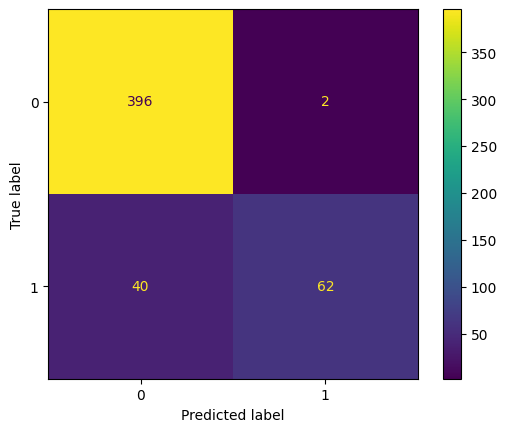

In [23]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred1)).plot()
plt.show()

Displaying Classification Report

In [24]:
print(classification_report(y_test, y_pred1))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95       398
           1       0.97      0.61      0.75       102

    accuracy                           0.92       500
   macro avg       0.94      0.80      0.85       500
weighted avg       0.92      0.92      0.91       500



#### ROC Curve for Random Forest Classifier

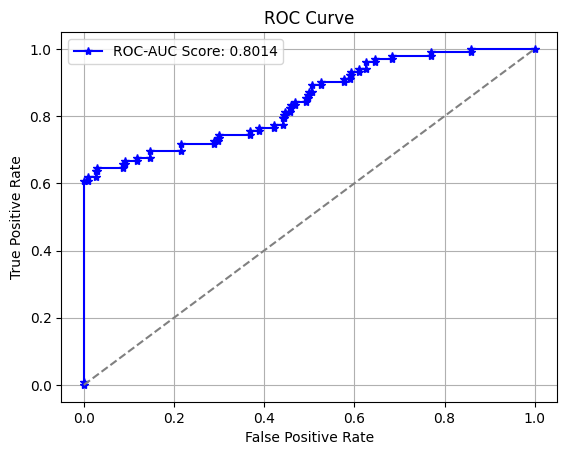

In [25]:
tpr1, fpr1, thresh1 = roc_curve(y_test, y_proba1[:, 1])

plt.plot(tpr1, fpr1, color='blue', marker='*', label=f'ROC-AUC Score: {roc1:.4f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.legend(loc='best')
plt.grid(True)
plt.show()

### XGBoost Classifier

Defining model parameters for better results

In [26]:
model2 = XGBClassifier(n_estimators=75, max_depth=10,learning_rate=0.4, random_state=42)

model2.fit(X_train, y_train)

y_proba2 = model2.predict_proba(X_test)
y_pred2 = (y_proba2[:, 1] >= 0.45).astype(int)         # It suggest that we must try to identify Team Rocket , even at cost of doubting an innocent (but at bareable Trade off is must

Obtaining Accuracy Score

In [27]:
acc2 = accuracy_score(y_test, y_pred2)

Obtaining ROC-AUC-Score

In [28]:
roc2 = roc_auc_score(y_test, y_pred2)

#### Confusion Matrix for XGBoost Classifier

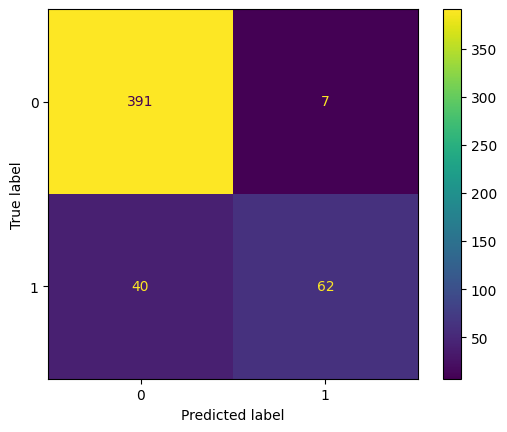

In [29]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred2)).plot()
plt.show()

Displaying Classification Report

In [30]:
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.91      0.98      0.94       398
           1       0.90      0.61      0.73       102

    accuracy                           0.91       500
   macro avg       0.90      0.80      0.83       500
weighted avg       0.91      0.91      0.90       500



#### ROC Curve for XGBoost Classifier

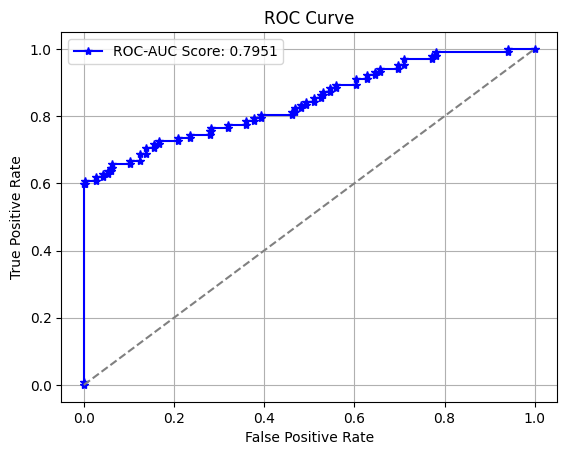

In [31]:
tpr2, fpr2, thresh2 = roc_curve(y_test, y_proba2[:, 1])

plt.plot(tpr2, fpr2, color='blue', marker='*', label=f'ROC-AUC Score: {roc2:.4f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.legend(loc='best')
plt.grid(True)
plt.show()

### Plotted an comparion plot

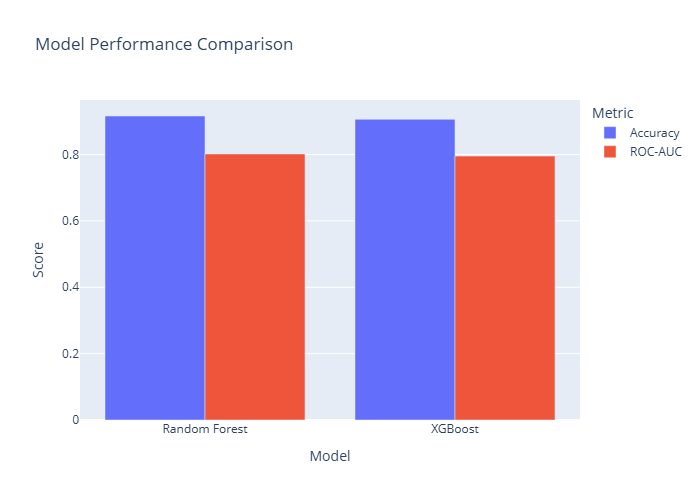

In [32]:
plots = {'Model': ['Random Forest', 'Random Forest', 'XGBoost', 'XGBoost'],
        'Metric': ['Accuracy', 'ROC-AUC', 'Accuracy', 'ROC-AUC'],
        'Score': [acc1, roc1, acc2, roc2]}
df_plots = pd.DataFrame(plots)

fig6 = px.bar(df_plots, x='Model', y='Score', color='Metric', barmode='group', title='Model Performance Comparison')
fig6.show()

 - We can get an strong indication that both `Random Forest Classifier` & `XGBoost Classifier` have almost equal accuracy and roc-auc scores.
 - To determine which model is best to generalize, we would consider few points
    - XGBoost Classifier has in-built regularization parameters, which would help us to not overfit our model.
    - Random Forest Classifier does not punish the model complexity.
    - XGB Classifier have many trees correcting previous mistakes which Random Forest Classifier does not.

So, we can conclude XGBoost Classifier as 'best' model here.

In [33]:
best_model = model2

best_model.fit(X_train, y_train)
best_y = best_model.predict(X_test)

In [34]:
print(f'Accuracy Score: {accuracy_score(y_test, best_y)}')
print(f'ROC-AUC Score: {roc_auc_score(y_test, best_y)})')

Accuracy Score: 0.91
ROC-AUC Score: 0.7976401615922751)
